In [2]:
!pip install kmodes kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importation des données et librairies

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from kmodes.kprototypes import KPrototypes

In [4]:
df=pd.read_csv("/content/drive/MyDrive/data_rfm.csv")
df=df.iloc[:, 1:]
df.head()

,review_score,Recence,Frequence,Montant
0,5.0,4,1,3
1,4.0,4,1,1
2,3.0,1,1,2
3,4.0,2,1,1
4,5.0,2,1,4


La colonne 'custumer_id n'est plus utile à la classification'

In [5]:
df.columns, df.shape

(Index(['review_score', 'Recence', 'Frequence', 'Montant'], dtype='object'),
 (95378, 4))

In [6]:
#df['review_score']=df['review_score'].astype("object")

In [7]:
quan=[i for i in df.columns if df[i].dtypes in ['float64', 'int64']]
qual=[i for i in df.columns if df[i].dtypes=='object']
#quan=[i for i in quan if i!="customer_id"]
#qual=[i for i in qual if i!='review_comment_message']
qual, quan

([], ['review_score', 'Recence', 'Frequence', 'Montant'])

# Standardisation

In [8]:
df.head()

,review_score,Recence,Frequence,Montant
0,5.0,4,1,3
1,4.0,4,1,1
2,3.0,1,1,2
3,4.0,2,1,1
4,5.0,2,1,4


In [9]:
for i in quan:
  df[i]=df[i].apply(lambda x: x if x>0 else 1)
  df[i]=df[i].apply(lambda x: np.log(x))

In [10]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, quan),
        ("cat", categorical_transformer, qual),
    ]
)

In [11]:
X=df#.values

In [12]:
X_train, X_test= train_test_split(X, test_size=0.2)
print(X_train.shape, X_test.shape)

(76302, 4) (19076, 4)


In [13]:
df.head()

,review_score,Recence,Frequence,Montant
0,1.609438,1.386294,0.0,1.098612
1,1.386294,1.386294,0.0,0.000000
2,1.098612,0.000000,0.0,0.693147
3,1.386294,0.693147,0.0,0.000000
4,1.609438,0.693147,0.0,1.386294


# Model

## 1.DBSCAN

Nous allons utiliser la mathode de coude ppour determiner le meilleur parametre eps

[0. 0. 0. ... 0. 0. 0.]
[0.         0.         0.         ... 1.74365372 1.91580164 2.11910975]


Text(0, 0.5, 'Distance')

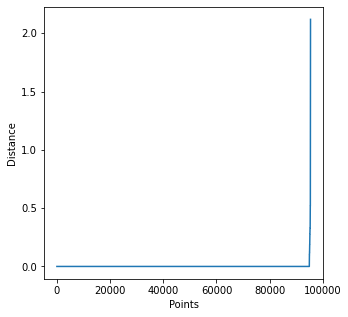

In [14]:
from sklearn.neighbors import NearestNeighbors
n_neighbors=  5
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
process=preprocessor.fit_transform(df)
neighbors = nearest_neighbors.fit(process)

distances, indices = neighbors.kneighbors(process)
print(distances[:,n_neighbors-1])
distances = np.sort(distances[:,n_neighbors-1], axis=0)
print(distances)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

0.0


<Figure size 360x360 with 0 Axes>

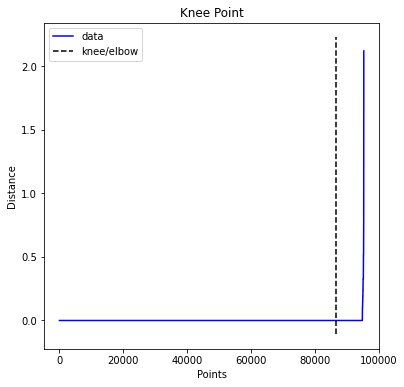

In [15]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [16]:
"""round(distances[knee.knee])
eps=round(distances[knee.knee], 2)
if eps==0:
  eps+=1
eps"""

'round(distances[knee.knee])\neps=round(distances[knee.knee], 2)\nif eps==0:\n  eps+=1\neps'

In [17]:
import sklearn
from sklearn.model_selection import GridSearchCV
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [37]:
X_std=preprocessor.fit_transform(X_train)
params={
     'eps' : [0.5, 1, 2] , 
      'min_samples':  [5],
      'p':[1, 2], 
       'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'metric': ['euclidean'], 
}


model2=DBSCAN()
model2=GridSearchCV(model2, param_grid=params, cv=5, scoring="adjusted_rand_score")
model2.get_params().keys()
model2.fit(X_std)

In [20]:
model2.best_params_

In [21]:
model3 = DBSCAN(eps=1, algorithm='auto', p=1)  #.best_estimator_
model=make_pipeline(preprocessor, model3)
model.fit(X_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['review_score', 'Recence',
                                                   'Frequence', 'Montant']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('dbscan', DBSCAN(eps=1, p=1))])

In [22]:
# Number of Clusters
labels=model3.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Nombre de cluster: %d' % N_clus)

Nombre de cluster: 12


In [23]:
#Calcul de la silhouette score
score=silhouette_score(preprocessor.transform(X_train), model3.labels_, metric='euclidean' )
print("silhouette_score= ", score )

silhouette_score=  0.4811146172223757


## 2. KMeans

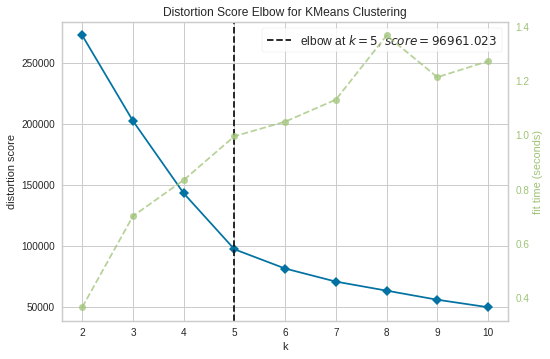

In [24]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(3,10)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

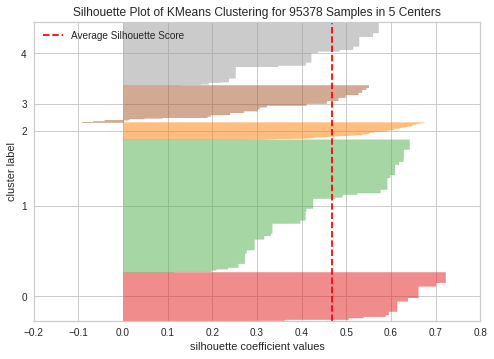

In [25]:
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

In [26]:
a=np.arange(1, 15)
liste=[]
for i in a:
  model1=KMeans(n_clusters=i)
  model=make_pipeline( preprocessor, model1)
  model.fit(X_train)
  liste.append(model1.inertia_)
liste

[305207.99999999977,
 245480.53076831118,
 162671.79912723973,
 114201.22399298743,
 77609.5352544096,
 65665.11915063745,
 57299.07375009962,
 49970.79244515025,
 44737.95250366808,
 40029.52486045119,
 36227.315810531225,
 34158.25390260709,
 32215.14168696518,
 29263.03419638201]

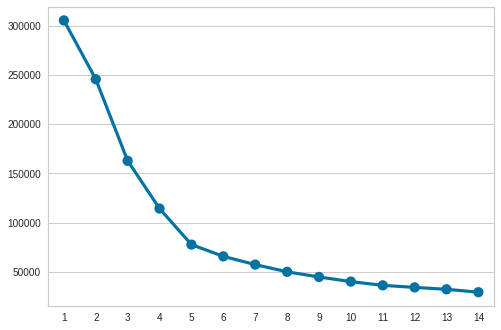

In [27]:
sns.pointplot(x = a, y = liste)

In [28]:
from sklearn.model_selection import GridSearchCV

params={
    'init':['k-means++', 'random'],
     'n_init': [5, 10, 15, 20], 
     'max_iter': [200, 300, 1000],
}


model1=KMeans(n_clusters=5)
model1=GridSearchCV(model1, param_grid=params, cv=5)
model1.get_params().keys()
X_std=preprocessor.fit_transform(X_train)
model1.fit(X_std)
model1.best_estimator_

KMeans(max_iter=200, n_clusters=5, n_init=15)

In [29]:
model1.best_params_

{'init': 'k-means++', 'max_iter': 200, 'n_init': 15}

In [30]:
X_train.shape
#model1=KMeans(n_clusters=5)#, max_iter=1000)
model1=KMeans(n_clusters=5, init= 'k-means++', max_iter= 300, n_init= 15)
model=make_pipeline(preprocessor , model1)
model.fit(X_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['review_score', 'Recence',
                                                   'Frequence', 'Montant']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('kmeans', KMeans(n_clusters=5, n_init=15))])

In [31]:
score = silhouette_score(X_std, model[-1].labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.468


In [32]:
model.predict(X_test)

array([2, 2, 0, ..., 2, 0, 0], dtype=int32)

In [33]:
set(model[-1].labels_)
set(model[-1].predict(X_train))
set(model[-1].labels_)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


{0, 1, 2, 3, 4}

In [34]:
df['cluster'] = model.predict(df)
colors = ['y', 'g', 'r', 'k', "b"]
df['c'] = df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4]})

In [35]:
df['cluster']=df['cluster'].astype('object')

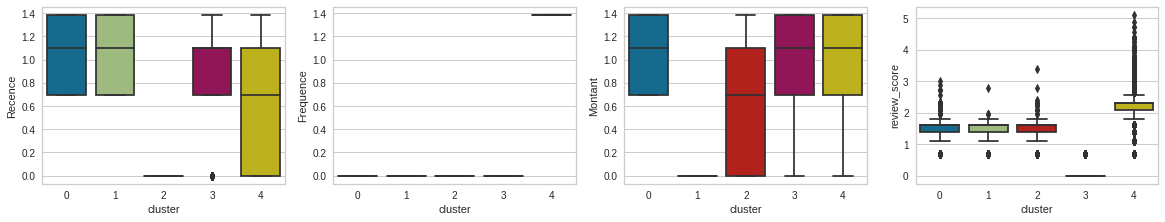

In [36]:
import seaborn as sns
fig = plt.figure(1, figsize=(20, 15))
for i,col in enumerate(['Recence', 'Frequence', "Montant", "review_score"]) :
    plt.subplot(4,4,i+1)
    sns.boxplot(data=df, x="cluster", y=col)
plt.show()

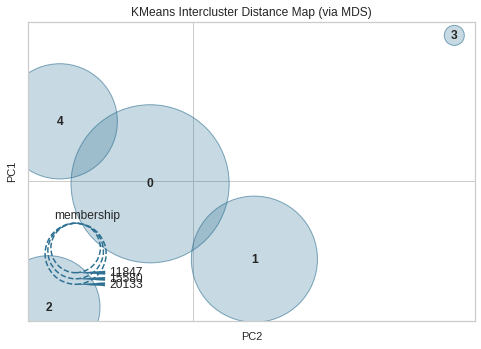

In [40]:
from yellowbrick.cluster import InterclusterDistance
from sklearn.pipeline import Pipeline
dist = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(n_clusters=5, init= 'k-means++', max_iter= 300, n_init= 15)))])
dist.fit(X)
dist.named_steps['distancevisualizer'].show()

# Conclusion


Nous allons choisir le KMeans car ce dernier a presque les meme perrformances que le DBSCAN mais est plus rapide en execution que le DBSCAN.
Nous allons donc le choisir et évaluer la fréquence de renouvellement du model dans le prochain notebook